# Customer Segmentation Modeling

**Overview**

In this project, I explore the **2019 Survey of Consumer Finances (SCFP)** dataset to understand the financial characteristics of small business owners in the United States. My goal is to identify distinct segments within this group using unsupervised machine learning. By analyzing high-variance financial features and applying **K-Means clustering** and **PCA**, I will create data-driven personas for small business owners. 📊

## 1. Setup ⚙️
**Importing Essential Libraries**

To kick off our analysis of small business owners in the United States, let's import the necessary libraries. We'll be using `pandas` for data manipulation, `seaborn` and `matplotlib` for traditional visualizations, and `plotly`, `dash` for creating interactive elements. We'll also import key modules from `scikit-learn` for our machine learning tasks, including `KMeans`, `PCA`, and `StandardScaler`.

In [1]:
# Import libraries here
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from dash import Input, Output, dcc, html
from IPython.display import VimeoVideo
from dash import Dash
from scipy.stats.mstats import trimmed_var
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)


## 2. Data Preparation 📋
**Importing the Dataset**

Now, let's load our data from the **2019 Survey of Consumer Finances (SCFP)**. We'll read the CSV file into a pandas DataFrame and then display its shape and the first few rows. This initial check is crucial to ensure that our data has been imported correctly and to get a first look at its structure.

In [2]:
df = pd.read_csv("data/SCFP2019.csv.gz")
print("df shape:", df.shape)
df.head()

df shape: (28885, 351)


,YY1,Y1,WGT,HHSEX,AGE,AGECL,EDUC,EDCL,MARRIED,KIDS,...,NWCAT,INCCAT,ASSETCAT,NINCCAT,NINC2CAT,NWPCTLECAT,INCPCTLECAT,NINCPCTLECAT,INCQRTCAT,NINCQRTCAT
0,1,11,6119.779308,2,75,6,12,4,2,0,...,5,3,6,3,2,10,6,6,3,3
1,1,12,4712.374912,2,75,6,12,4,2,0,...,5,3,6,3,1,10,5,5,2,2
2,1,13,5145.224455,2,75,6,12,4,2,0,...,5,3,6,3,1,10,5,5,2,2
3,1,14,5297.663412,2,75,6,12,4,2,0,...,5,2,6,2,1,10,4,4,2,2
4,1,15,4761.812371,2,75,6,12,4,2,0,...,5,3,6,3,1,10,5,5,2,2


## 3. Exploratory Data Analysis 📊
**Proportion of Business Owners**

Before diving deeper, let's get a baseline understanding of our dataset. We'll start by calculating the proportion of households that own a business. This will give us a sense of the distribution between business owners and non-business owners in the survey.

In [3]:
prop_biz_owners = df["HBUS"].value_counts(normalize=True).min()
print("proportion of business owners in df:", prop_biz_owners)

proportion of business owners in df: 0.2740176562229531


**Income Distribution Analysis**

Next, we'll explore the income distribution. To make the `INCCAT` (Income Category) column more readable, we'll replace the numerical codes with their corresponding percentile ranges. Then, we'll group the data by business ownership (`HBUS`) to see how income is distributed within each group.

In [4]:
inccat_dict = {
    1: "0-20",
    2: "21-39.9",
    3: "40-59.9",
    4: "60-79.9",
    5: "80-89.9",
    6: "90-100",
}
df_inccat = (df["INCCAT"].replace(inccat_dict)
             .groupby(df["HBUS"])
             .value_counts(normalize=True)
             .rename("frequency")
             .reset_index()
             )

df_inccat

,HBUS,INCCAT,frequency
0,0,0-20,0.210348
1,0,21-39.9,0.198140
2,0,40-59.9,0.189080
3,0,60-79.9,0.186600
4,0,90-100,0.117167
5,0,80-89.9,0.098665
6,1,90-100,0.629438
7,1,60-79.9,0.119015
8,1,80-89.9,0.097410
9,1,40-59.9,0.071510


**Visualizing Income Distribution 📈**

A visual representation often tells a clearer story. Let's create a bar plot to compare the income distributions of business owners versus non-business owners. This will help us quickly identify any significant differences in income levels between the two groups.

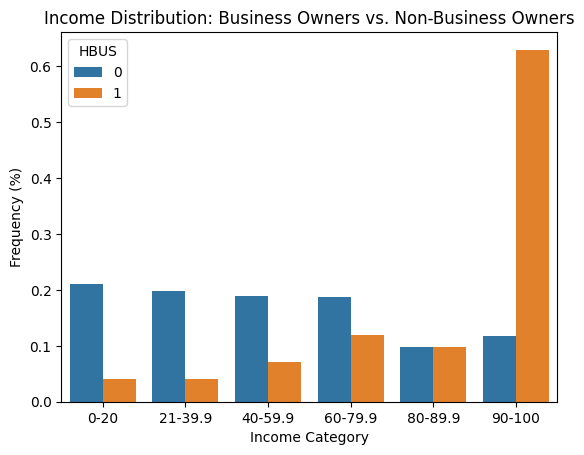

In [5]:
fig, ax = plt.subplots()

sns.barplot(
    x="INCCAT",
    y="frequency",
    hue="HBUS",
    order=inccat_dict.values(),
    ax=ax,
    data=df_inccat
);
plt.xlabel("Income Category")
plt.ylabel("Frequency (%)")
plt.title("Income Distribution: Business Owners vs. Non-Business Owners");



**Home Value vs. Household Debt**

Let's investigate the relationship between household debt and the value of primary residences. By creating a scatter plot and color-coding the points based on business ownership, we can look for patterns or clusters that might indicate different financial behaviors between the two groups.

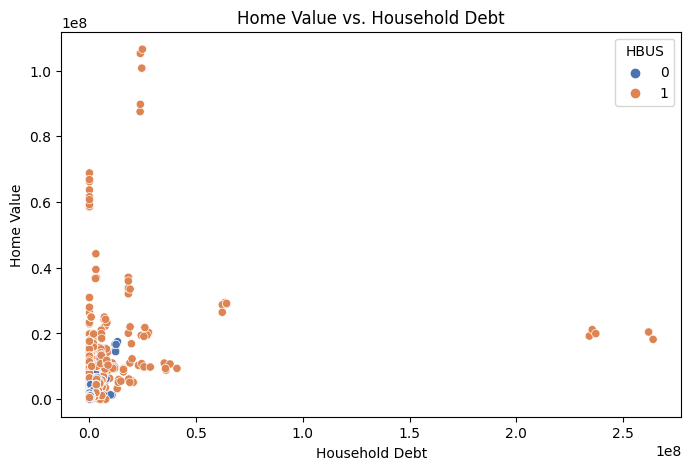

In [6]:
# Plot "HOUSES" vs "DEBT" with hue as business ownership
fig, ax = plt.subplots(figsize=(8, 5))

sns.scatterplot(
    data=df,
    x="DEBT",
    y="HOUSES",
    hue="HBUS",
    palette="deep",
    ax=ax
)
plt.xlabel("Household Debt")
plt.ylabel("Home Value")
plt.title("Home Value vs. Household Debt");


**Filtering for Small Business Owners**

For the core of our analysis, we need to focus on a specific segment: small business owners. We'll create a new DataFrame, `df_small_biz`, by filtering the original data to include only households that own a business and have an income below $500,000. This ensures we're not including large corporations in our analysis.

In [7]:
mask = (df["HBUS"] == 1) & (df["INCOME"] <5e5)
df_small_biz = df.query("HBUS == 1 and INCOME < 500_000")
# use the column `mask` defined above
print("df_small_biz shape:", df_small_biz.shape)
df_small_biz.head()

df_small_biz shape: (4364, 351)


,YY1,Y1,WGT,HHSEX,AGE,AGECL,EDUC,EDCL,MARRIED,KIDS,...,NWCAT,INCCAT,ASSETCAT,NINCCAT,NINC2CAT,NWPCTLECAT,INCPCTLECAT,NINCPCTLECAT,INCQRTCAT,NINCQRTCAT
80,17,171,7802.265717,1,62,4,12,4,1,0,...,3,5,5,5,2,7,9,9,4,4
81,17,172,8247.536301,1,62,4,12,4,1,0,...,3,5,5,5,2,7,9,9,4,4
82,17,173,8169.562719,1,62,4,12,4,1,0,...,3,5,5,5,2,7,9,9,4,4
83,17,174,8087.704517,1,62,4,12,4,1,0,...,3,5,5,5,2,7,9,9,4,4
84,17,175,8276.510048,1,62,4,12,4,1,0,...,3,5,5,5,2,7,9,9,4,4


**Age Distribution of Small Business Owners**

Understanding the demographics of our target group is essential. Here, we'll plot a histogram of the ages of the small business owners in our filtered DataFrame. This will give us insight into the typical age range of these entrepreneurs.

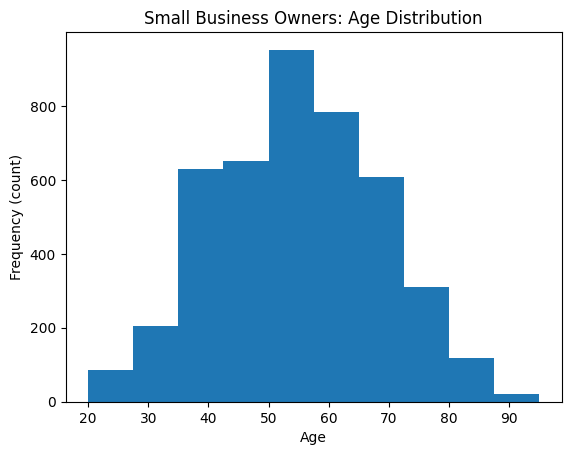

In [10]:
# Plot histogram of "AGE"
fig, ax = plt.subplots()
df_small_biz["AGE"].plot(kind="hist" ,ax=ax)
plt.xlabel("Age")
plt.ylabel("Frequency (count)")
plt.title("Small Business Owners: Age Distribution");



## 4. Feature Engineering 🛠️
**Identifying High-Variance Features**

To build a meaningful clustering model, we need to identify the most informative features. We'll start by calculating the variance of all numerical columns in our `df_small_biz` DataFrame and examining the top ten features with the highest variance. These are likely to be the most influential variables in differentiating between groups of business owners.

In [15]:
# Calculate variance, get 10 largest features
top_ten_var = df_small_biz.var().sort_values().tail(10)
top_ten_var

EQUITY      1.005088e+13
FIN         2.103228e+13
KGBUS       5.025210e+13
ACTBUS      5.405021e+13
BUS         5.606717e+13
KGTOTAL     6.120760e+13
NHNFIN      7.363197e+13
NFIN        9.244074e+13
NETWORTH    1.424450e+14
ASSET       1.520071e+14
dtype: float64

**Robust Feature Selection with Trimmed Variance**

Standard variance can be heavily influenced by outliers. To get a more robust measure, we'll calculate the *trimmed variance* for each feature, which excludes the top and bottom 10% of values. This will help us confirm that the features we've identified are genuinely significant and not just skewed by extreme values.

In [23]:
# Calculate trimmed variance
top_ten_trim_var = (
    df_small_biz.apply(trimmed_var,limits=(0.1,0.1)).sort_values().tail(10)
)

top_ten_trim_var

EQUITY      1.177020e+11
KGBUS       1.838163e+11
FIN         3.588855e+11
KGTOTAL     5.367878e+11
ACTBUS      5.441806e+11
BUS         6.531708e+11
NHNFIN      1.109187e+12
NFIN        1.792707e+12
NETWORTH    3.726356e+12
ASSET       3.990101e+12
dtype: float64

Let's do a quick visualization of those values.

**Visualizing Feature Importance**

Let's create a bar chart to visualize the top ten features based on their trimmed variance. This will provide a clear, at-a-glance view of the financial characteristics that vary the most among small business owners, guiding our model-building process.

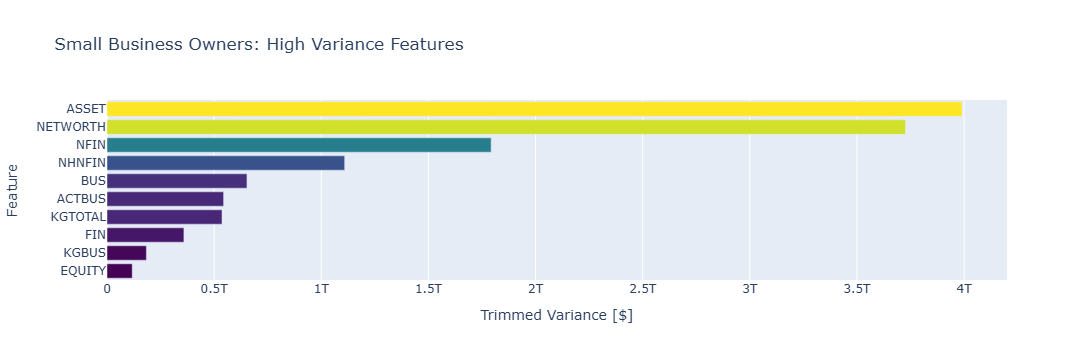

In [103]:
import plotly.express as px

fig = px.bar(
    x=top_ten_trim_var,
    y=top_ten_trim_var.index,
    orientation='h',
    color=top_ten_trim_var.values,  # Color bars by variance
    color_continuous_scale='Viridis',  # You can try 'Turbo', 'Plasma', 'Cividis', etc.
    title="Small Business Owners: High Variance Features"
)

fig.update_layout(
    xaxis_title="Trimmed Variance [$]",
    yaxis_title="Feature",
    coloraxis_showscale=False  # Optional: Hide color bar
)

fig.show()


**Selecting Final Features**

Based on our variance analysis, we'll now select the top five highest-variance features. These columns—`BUS`, `NHNFIN`, `NFIN`, `NETWORTH`, and `ASSET`—will form the basis of our feature matrix `X` for the clustering model.

In [30]:
high_var_cols = list(top_ten_trim_var.tail().index)
high_var_cols

['BUS', 'NHNFIN', 'NFIN', 'NETWORTH', 'ASSET']

## 5. Model Building 🧩
**Creating the Feature Matrix**

With our key features identified, it's time to build the feature matrix `X`. This DataFrame will contain only the five high-variance columns we selected, which our K-Means model will use to segment the small business owners.

In [38]:
X = df_small_biz[high_var_cols]
print("X shape:", X.shape)
X.head()

X shape: (4364, 5)


,BUS,NHNFIN,NFIN,NETWORTH,ASSET
80,0.0,224000.0,724000.0,237600.0,810600.0
81,0.0,223000.0,723000.0,236600.0,809600.0
82,0.0,224000.0,724000.0,237600.0,810600.0
83,0.0,222000.0,722000.0,234600.0,808600.0
84,0.0,223000.0,723000.0,237600.0,809600.0


**Finding the Optimal Number of Clusters (k)**

The performance of a K-Means model heavily depends on choosing the right number of clusters, `k`. We'll iterate through a range of values for `k` (from 2 to 12) and, for each value, we'll build a pipeline that scales the data and fits a K-Means model. We'll store the inertia and silhouette scores for each iteration to evaluate which `k` is optimal.

In [45]:
n_clusters = range(2,13)
inertia_errors = []
silhouette_scores = []

# Add `for` loop to train model and calculate inertia, silhouette score.
for k in n_clusters :
    model = make_pipeline(StandardScaler(), KMeans(n_clusters=k , random_state=42))
    model.fit(X)
    inertia_errors.append(model.named_steps["kmeans"].inertia_)
    silhouette_scores.append(silhouette_score(X,model.named_steps["kmeans"].labels_))

print("Inertia:", inertia_errors[:11])
print()
print("Silhouette Scores:", silhouette_scores[:3])

Inertia: [5765.863949365048, 3070.4294488357455, 2220.292185089684, 1777.4635570665569, 1441.6688198736526, 1173.3701169574997, 1050.6442581214994, 881.6578582242295, 774.6415287114439, 666.0292729241072, 624.442491985052]

Silhouette Scores: [0.9542706303253067, 0.8446503900103915, 0.7422220122162623]


**Evaluating Inertia: The Elbow Method**

One way to determine the best `k` is the "elbow method." We'll plot the inertia scores for each value of `k`. The "elbow" of the curve—the point where the rate of decrease in inertia slows down—suggests the optimal number of clusters.

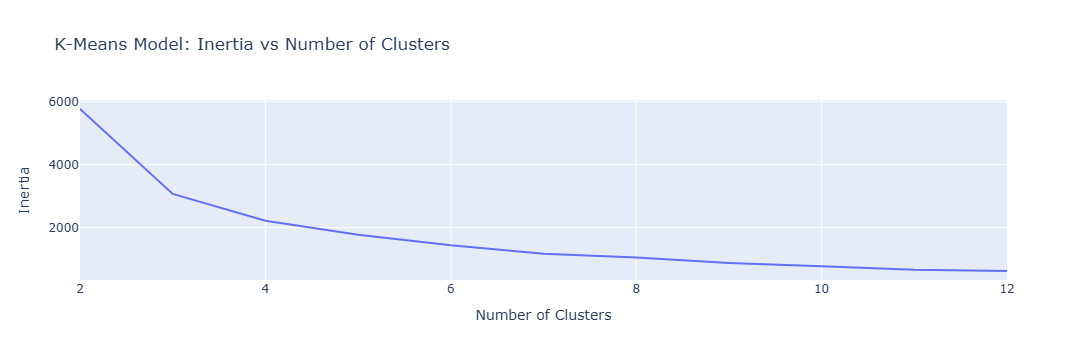

In [113]:
import plotly.express as px

fig = px.line(
    x=n_clusters,
    y=inertia_errors,
    title="K-Means Model: Inertia vs Number of Clusters",
    line_shape="linear",  # optional for smoother style: 'spline'
)


# Axis titles
fig.update_layout(
    xaxis_title="Number of Clusters",
    yaxis_title="Inertia"
)

fig.show()


**Evaluating Cluster Separation: Silhouette Scores**

Another powerful metric is the silhouette score, which measures how well-separated the clusters are. We'll plot the silhouette scores for each `k`. A higher score indicates better-defined clusters. This, combined with the elbow method, will give us confidence in our choice of `k`.

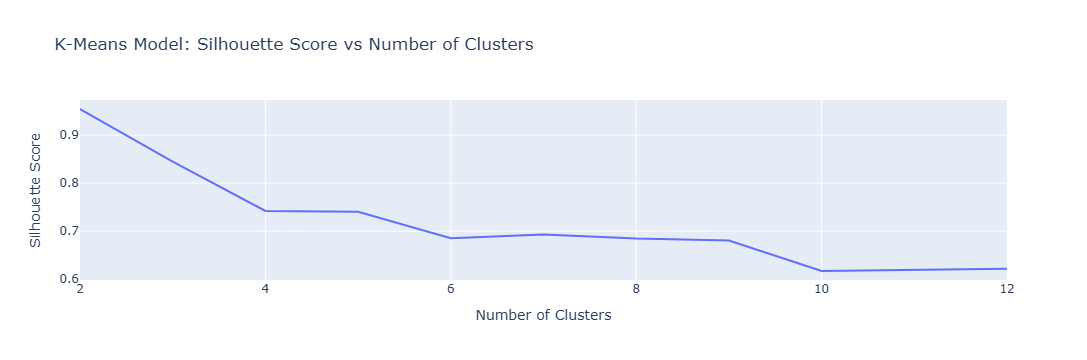

In [110]:
import plotly.express as px

fig = px.line(
    x=n_clusters,
    y=silhouette_scores,
    title="K-Means Model: Silhouette Score vs Number of Clusters",
)

# 🏷️ Axis labels
fig.update_layout(
    xaxis_title="Number of Clusters",
    yaxis_title="Silhouette Score"
)

fig.show()


**Building the Final Model**

Based on our analysis of the inertia and silhouette scores, a `k` of 3 appears to be the sweet spot. Let's build our final model using three clusters. This model will segment our small business owners into three distinct financial profiles.

In [62]:
final_model = make_pipeline(StandardScaler(), KMeans(n_clusters=3 , random_state=42)).fit(X)

## 6. Communicating Results 📣
**Analyzing Cluster Centers**

Now that we have our clusters, let's examine what defines them. We'll extract the labels assigned by our final model and then calculate the mean value of each feature for each cluster. This will reveal the financial characteristics of each group.

In [70]:
labels = final_model.named_steps["kmeans"].labels_
xgb = X.groupby(labels).mean()
xgb

,BUS,NHNFIN,NFIN,NETWORTH,ASSET
0,7.367185e+05,1.002199e+06,1.487967e+06,2.076003e+06,2.281249e+06
1,1.216152e+07,1.567619e+07,1.829123e+07,2.310024e+07,2.422602e+07
2,6.874479e+07,8.202115e+07,9.169652e+07,1.134843e+08,1.167529e+08


**Visualizing Cluster Characteristics**

To make our findings more intuitive, we'll create a side-by-side bar chart that compares the mean feature values for each of our three clusters. This visualization will clearly illustrate the differences in asset and wealth distribution among the identified segments of small business owners.

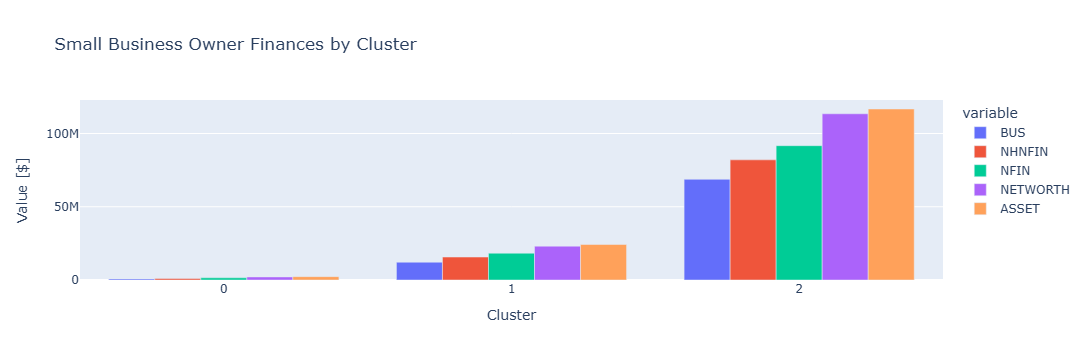

In [99]:
# Create side-by-side bar chart of `xgb`
fig=px.bar(data_frame=xgb ,
       barmode="group", 
       title="Small Business Owner Finances by Cluster",
      )
fig.update_layout(xaxis_title="Cluster",yaxis_title="Value [$]")
fig.show()

**Dimensionality Reduction with PCA**

Visualizing clusters in a five-dimensional space is impossible. To overcome this, we'll use **Principal Component Analysis (PCA)** to reduce our five features down to two principal components. This will allow us to create a 2D scatter plot while still capturing the most important variance in the data.

In [82]:
# Instantiate transformer
pca = PCA(n_components=2,random_state=42)

# Transform `X`
X_t = pca.fit_transform(X)

# Put `X_t` into DataFrame
X_pca = pd.DataFrame(X_t, columns=["PC1","PC2"])

print("X_pca shape:", X_pca.shape)
X_pca.head()

X_pca shape: (4364, 2)


,PC1,PC2
0,-6.220648e+06,-503841.638835
1,-6.222523e+06,-503941.888901
2,-6.220648e+06,-503841.638839
3,-6.224927e+06,-504491.429465
4,-6.221994e+06,-503492.598399


**Visualizing the Clusters with PCA 🎯**

Finally, let's bring it all together in a scatter plot. We'll plot the two principal components against each other and color-code the points based on their assigned cluster from our K-Means model. This plot will provide a powerful visual representation of the distinct segments of small business owners we've uncovered.

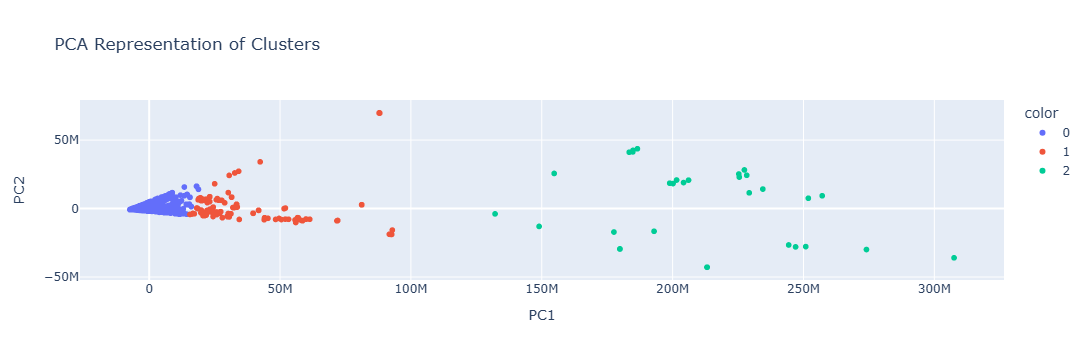

In [109]:
# Create scatter plot of `PC2` vs `PC1`
fig=px.scatter(data_frame=X_pca ,x="PC1",y="PC2" ,color=labels.astype(str), title="PCA Representation of Clusters")
fig.update_layout(xaxis_title="PC1", yaxis_title="PC2")
fig.show()

# Conclusion 🎯

In this analysis, I successfully segmented small business owners into three distinct financial groups. By leveraging **trimmed variance** for robust feature selection and **PCA** for dimensionality reduction, the K-Means clustering model was able to reveal clear patterns in the data.

The final visualizations show that these groups are primarily distinguished by their level of **assets and net worth**, creating personas ranging from modest entrepreneurs to high-net-worth business owners. This project demonstrates the power of unsupervised learning to uncover hidden structures in complex financial datasets. Keep exploring, and let data guide your insights! 🌟